# DTW and SparseDTW
## Implementation and comparison

In [371]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
%matplotlib inline

Some data for testing

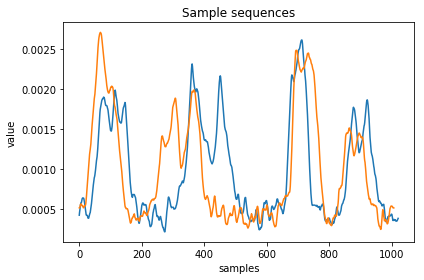

In [252]:
seq0 = np.load('./seq0.npy')
seq1 = np.roll(np.load('./seq1.npy'), 200)
plt.plot(seq0)
plt.plot(seq1)
plt.title('Sample sequences')
plt.xlabel('samples')
plt.ylabel('value')
plt.tight_layout()
#plt.savefig('./sequences.pdf')
plt.show()

In [293]:
from scipy.sparse import lil_matrix
import itertools

class DTW:
    """Dynamic time warping with custom distance function: DTW and SparseDTW implementation"""

    def __init__(self, _score):
        """_score: distance function, e.g. lambda a,b: (a-b)**2"""
        self.scoref = _score
        
    def align(self, _x, _y):
        """Standard DTW; 
        x and y: any iterables.
        Returns: alignment string representation 
        (a:align, x:skip element in x, y: skip element in y)
        and final score (sum of scores on optimal path)"""
        
        x = list(_x)
        y = list(_y)
        
        #init scores matrix
        scores = np.zeros((len(x)+1, len(y)+1))
        scores[1:,0] = np.inf
        scores[0,1:] = np.inf
        
        #pre-compute all pairwise distances
        scorexy = np.array([[self.scoref(u,v) for v in y] for u in x])
        self.scorexy = scorexy
        
        #core loop of DTW: dynamic scoring
        for i in range(1,len(x)+1):
            for j in range(1, len(y)+1):
                tmp = [scores[i-1,j], scores[i-1,j-1], scores[i,j-1]]
                s = min(tmp)
                scores[i,j] = s+scorexy[i-1,j-1]
        
        #final path backtracking, compute string representation and corresponding indices
        align = []
        i = len(x)
        j = len(y)
        xi = []
        yj = []
        symbols = {0:'a', 1:'x', 2:'y'}
        while (i>0) or (j>0):
            xi.append(i-1)
            yj.append(j-1)
            amin = np.argmin([scores[i-1,j-1], scores[i-1,j], scores[i,j-1]])
            align.append(symbols[amin])
            i,j = [(i-1,j-1), (i-1,j), (i,j-1)][amin]

        #indices are stored in xi, yj
        self.scores = scores
        self.xi = xi[::-1]
        self.yj = yj[::-1]
        return ''.join(align[::-1]), scores[-1, -1]
    
    def sparse_align(self, _x, _y, bins=10, overlap=2, checkpoint=True):
        """SparseDTW implementation: https://arxiv.org/pdf/1201.2969.pdf 
        x and y: numeric iterables.
        bins: number of bins to quantize sequences.
        overlap: multiplier for default bin width to make bins overlap (1 means no overlap).
        Returns: alignment string representation 
        (a:align, x:skip element in x, y: skip element in y)
        and final score (sum of scores on optimal path)"""
        
        x = np.array(_x, dtype=float)
        y = np.array(_y, dtype=float)

        #init sparse score matrix
        scores = lil_matrix((len(x), len(y)), dtype=float)
        
        #normalize sequences
        qx = (x-x.min())/(x.max()-x.min())
        qy = (y-y.min())/(y.max()-y.min())
        
        #make overlapping bins
        bw = 1.0/bins
        lb = np.arange(bins)*bw
        hb = lb + bw*overlap
        
        #quantize sequences into bins, mark overlapping indices in score matrix
        #-1 is used here to replace 0
        for l,h in zip(lb,hb):
            indx = np.where(np.logical_and(l<=qx, qx<=h))[0]
            indy = np.where(np.logical_and(l<=qy, qy<=h))[0]
            for i,j in itertools.product(indx, indy):
                s = self.scoref(x[i],y[j])
                scores[i,j] = (s if s>0 else -1)
        
        if checkpoint:
            self.scores0 = scores.copy()
        
        #for all cells: if cell has no bottom/right neighbors, create them
        current = list(zip(*scores.nonzero()))
        current_set = set(zip(*scores.nonzero()))
        while(len(current)>0):
            i,j = current.pop(0)
            current_set -= {(i,j)}
            top = [e for e in [(i+1,j+1), (i+1,j), (i,j+1)] if e in current_set]
            if len(top)>0:
                continue
            top = [e for e in [(i+1,j+1), (i+1,j), (i,j+1)] 
                   if ((e[0]<len(x)) and (e[1]<len(y)))]
            for e in top:
                s = self.scoref(x[e[0]],y[e[1]])
                scores[e] = (s if s>0 else -1)
                current.append(e)
                current_set |= {e}
              
        if checkpoint:
            self.scores1 = scores.copy()
        
        #for all cells: if cell has no top/left neighbors, create them
        current = list(zip(*scores.nonzero()))[::-1]
        current_set = set(zip(*scores.nonzero()))
        while(len(current)>0):
            i,j = current.pop(0)
            current_set -= {(i,j)}
            top = [e for e in [(i-1,j-1), (i-1,j), (i,j-1)] if e in current_set]
            if len(top)>0:
                continue
            top = [e for e in [(i-1,j-1), (i-1,j), (i,j-1)] 
                   if ((e[0]>=0) and (e[1]>=0))]
            for e in top:
                s = self.scoref(x[e[0]],y[e[1]])
                scores[e] = (s if s>0 else -1)
                current.append(e)
                current_set |= {e}
          
        if checkpoint:
            self.scores2 = scores.copy()
        
        #core loop of SparseDTW: same as DTW, but use only non-zero cells
        nonzero = set(zip(*scores.nonzero()))
        for i,j in zip(*scores.nonzero()):
            bottom = [e for e in [(i-1,j-1), (i-1,j), (i,j-1)] if e in nonzero]
            if len(bottom)==0:
                continue
            vals = [max([scores[e], 0]) for e in bottom] 
            s = min(vals) + max([scores[i,j],0])
            scores[i,j] = (s if s>0 else -1)
            
        self.scores = scores
            
        #backtrack optimal path: same as DTW, but use only non-zero cells
        align = []
        i = len(x)-1
        j = len(y)-1
        self.xi = []
        self.yj = []
        while (i>0) or (j>0):
            self.xi.append(i)
            self.yj.append(j)
            bottom = [e for e in [(i-1,j-1,'a'), (i-1,j,'x'), (i,j-1,'y')] if e[:2] in nonzero]
            ind = np.argmin([scores[e[:2]] for e in bottom])
            align.append(bottom[ind][2])
            i,j = bottom[ind][:2]
        self.xi.append(0)
        self.yj.append(0)
        align.append('a')
        self.xi = self.xi[::-1]
        self.yj = self.yj[::-1]
        return ''.join(align[::-1]), scores[-1, -1]
    
    def string_repr(self, _x, _y, al):
        """String representation of sequences with skips: to display short sequences"""
        x = [str(e) for e in _x]
        y = [str(e) for e in _y]
        xr = []
        yr = []
        i = 0
        j = 0
        for a in al:
            if a=='a':
                xr.append(x[i])
                yr.append(y[j])
                i = i+1
                j = j+1
            elif a=='y':
                xr.append('-')
                yr.append(y[j])
                j = j+1
            else:
                yr.append('-')
                xr.append(x[i])
                i = i+1
        return ''.join(xr), ''.join(yr)
    
    def construct(self, _x, _y, al):
        """Construct sequences with 0s for skips"""
        x = [float(e) for e in _x]
        y = [float(e) for e in _y]
        xr = []
        yr = []
        i = 0
        j = 0
        for a in al:
            if a=='a':
                xr.append(x[i])
                yr.append(y[j])
                i = i+1
                j = j+1
            elif a=='y':
                xr.append(0)
                yr.append(y[j])
                j = j+1
            else:
                yr.append(0)
                xr.append(x[i])
                i = i+1
        xr = np.array(xr) 
        yr = np.array(yr)
        return xr, yr
    
    def plot(self, _x, _y, al):
        """Plot sequence alignment"""
        x = [float(e) for e in _x]
        y = [float(e) for e in _y]
        xr = []
        yr = []
        i = 0
        j = 0
        for a in al:
            if a=='a':
                xr.append(x[i])
                yr.append(y[j])
                i = i+1
                j = j+1
            elif a=='y':
                xr.append(0)
                yr.append(y[j])
                j = j+1
            else:
                yr.append(0)
                xr.append(x[i])
                i = i+1
        xr = np.array(xr) 
        yr = np.array(yr)
        gpx = np.arange(len(al))[np.array([(e!='a') for e in al])]
        gpy = np.zeros(gpx.shape)
        plt.plot(xr, 'b-')
        plt.plot(yr, 'g-')
        plt.plot(gpx, gpy, 'rx')   

Use minkowski distance with p=0.1 to perform less aggressive alignment

In [277]:
ff = lambda a,b: abs(a-b)**(0.1)

# Regular DTW

Final score:  423.18615399


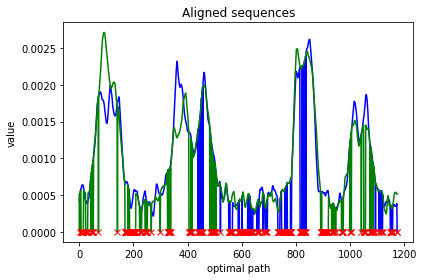

In [288]:
Al1 = DTW(ff)
a1,s1 = Al1.align(seq0, seq1)
print('Final score: ', s1)
Al1.plot(seq0, seq1, a1)
plt.xlabel('optimal path')
plt.ylabel('value')
plt.title('Aligned sequences')
plt.tight_layout()
plt.savefig('./aligned.pdf')
plt.show()

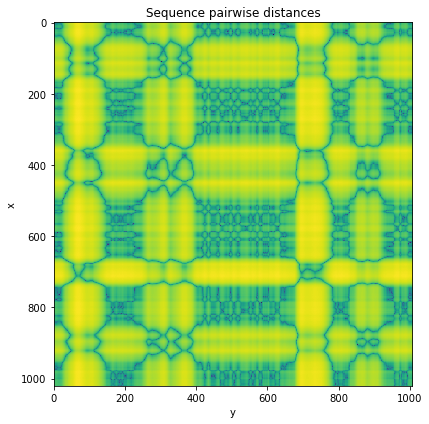

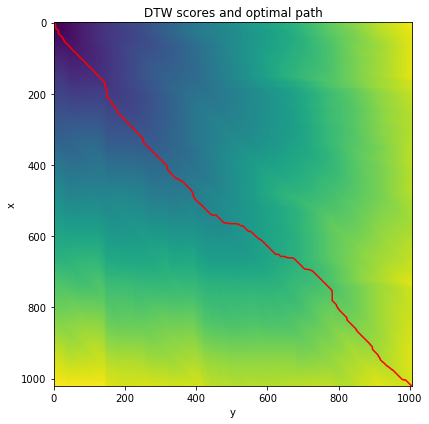

In [289]:
plt.figure(figsize=(6,6))
plt.imshow(Al1.scorexy)
plt.xlabel('y')
plt.ylabel('x')
plt.title('Sequence pairwise distances')
plt.tight_layout()
plt.savefig('./dtw_dist.pdf')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(Al1.yj, Al1.xi, 'r')
plt.imshow(Al1.scores[1:,1:])
plt.xlabel('y')
plt.ylabel('x')
plt.title('DTW scores and optimal path')
plt.tight_layout()
plt.savefig('./dtw_score.pdf')
plt.show()

# SparseDTW

Final score:  426.769839783


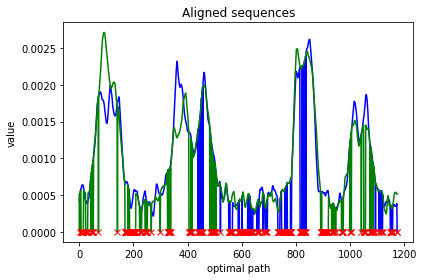

In [294]:
Al2 = DTW(ff)
a2,s2 = Al2.sparse_align(seq0, seq1, 6)
print('Final score: ', s2)
Al1.plot(seq0, seq1, a1)
plt.xlabel('optimal path')
plt.ylabel('value')
plt.title('Aligned sequences')
plt.tight_layout()
plt.show()

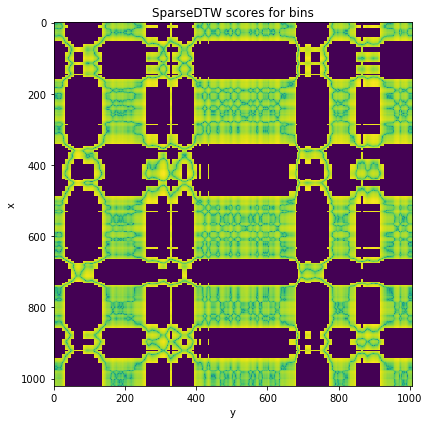

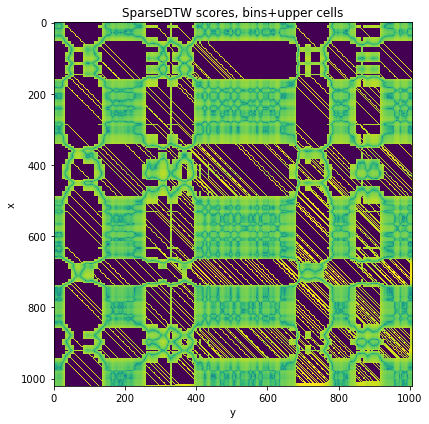

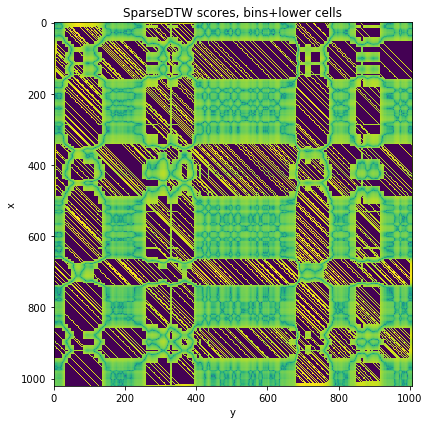

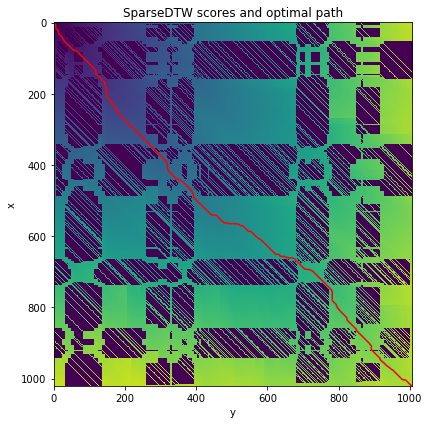

In [295]:
plt.figure(figsize=(6,6))
plt.imshow(Al2.scores0.toarray())
plt.xlabel('y')
plt.ylabel('x')
plt.title('SparseDTW scores for bins')
plt.tight_layout()
plt.savefig('./sparse_bins.pdf')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(Al2.scores1.toarray())
plt.xlabel('y')
plt.ylabel('x')
plt.title('SparseDTW scores, bins+upper cells')
plt.tight_layout()
plt.savefig('./sparse_upper.pdf')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(Al2.scores2.toarray())
plt.xlabel('y')
plt.ylabel('x')
plt.title('SparseDTW scores, bins+lower cells')
plt.tight_layout()
plt.savefig('./sparse_lower.pdf')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(Al2.scores.toarray())
plt.plot(Al2.yj, Al2.xi, 'r')
plt.xlabel('y')
plt.ylabel('x')
plt.title('SparseDTW scores and optimal path')
plt.tight_layout()
plt.savefig('./sparse_score.pdf')
plt.show()

# Dependency on bins number

(This section takes a lot of time)

In [312]:
lim=1500
scores = []
density = []
for b in [2,3,4,5,6,7,8,9,10]:
    print(b)
    Al = DTW(ff)
    a, sc = Al.sparse_align(seq0[:lim], seq1[:lim], b)
    dn = Al.scores.count_nonzero()/(Al.scores.shape[0]*Al.scores.shape[1])
    scores.append(np.sqrt(sc)/len(a))
    density.append(dn)

2
3
4
5
6
7
8
9
10


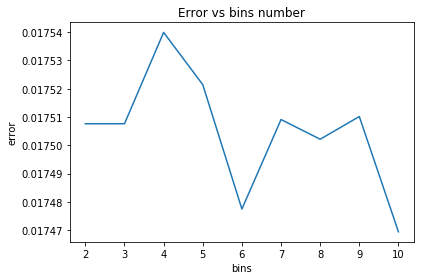

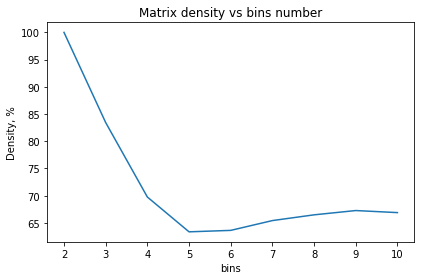

In [315]:
plt.plot([2,3,4,5,6,7,8,9,10], scores)
plt.title('Error vs bins number')
plt.xlabel('bins')
plt.ylabel('error')
plt.tight_layout()
#plt.savefig('./sparse_binscore.pdf')
plt.show()

plt.plot([2,3,4,5,6,7,8,9,10], np.array(density)*100)
plt.title('Matrix density vs bins number')
plt.xlabel('bins')
plt.ylabel('Density, %')
plt.tight_layout()
#plt.savefig('./sparse_bindense.pdf')
plt.show()

# Reverse sequences example for Sparse DTW

Total score:  67.2756551328


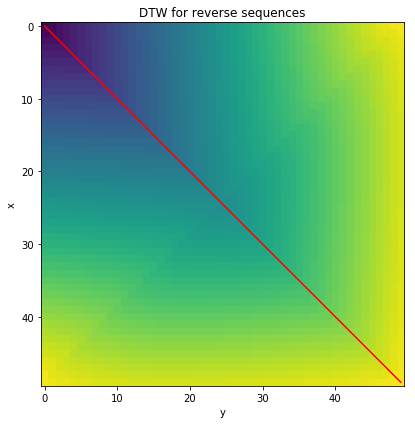

In [317]:
x = np.arange(50)
y = np.arange(50)[::-1]

Al = DTW(ff)
a, sc = Al.align(x, y)
print('Total score: ', sc)
plt.figure(figsize=(6,6))
plt.imshow(Al.scores[1:,1:])
plt.plot(Al.yj, Al.xi, 'r')
plt.xlabel('y')
plt.ylabel('x')
plt.title('DTW for reverse sequences')
plt.tight_layout()
plt.savefig('./reverse_dtw.pdf')
plt.show()

Total score:  73.6614731526


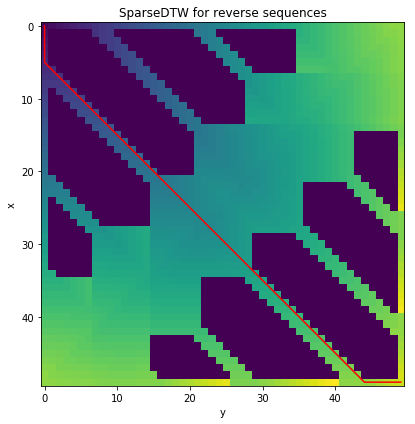

In [321]:
Al = DTW(ff)
a, sc = Al.sparse_align(x, y, 7)
print('Total score: ', sc)
plt.figure(figsize=(6,6))
plt.imshow(Al.scores.toarray())
plt.plot(Al.yj, Al.xi, 'r')
plt.xlabel('y')
plt.ylabel('x')
plt.title('SparseDTW for reverse sequences')
plt.tight_layout()
plt.savefig('./reverse_sparse.pdf')
plt.show()

# Audio

In [322]:
import librosa
import librosa.display
from IPython.display import Audio, display

In [338]:
def cut_sound(sound, level=0.05, newmax=0.3):
    """Cut off part with >level% intensity, scale with newmax"""
    t = np.where(np.abs(sound)>level*np.max(np.abs(sound)))[0]
    t = sound[t[0]:t[-1]]
    return t/np.max(np.abs(t))*newmax

Load data

In [343]:
sr = 8000
five, sr = librosa.load('./five.wav', sr=sr)
five = cut_sound(five)
print('Five')
display(Audio(data=five, rate=sr))
four, sr = librosa.load('./four.wav', sr=sr)
four = cut_sound(four)
print('Four')
display(Audio(data=four, rate=sr))
nine, sr = librosa.load('./nine.wav', sr=sr)
nine = cut_sound(nine)
print('Nine')
display(Audio(data=nine, rate=sr))

Five


Four


Nine


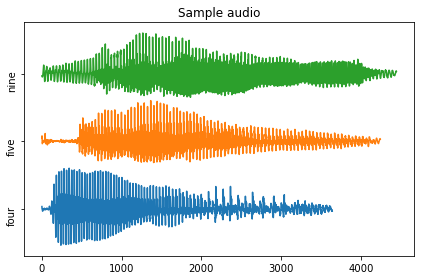

In [355]:
plt.plot(four)
plt.plot(five+0.5)
plt.plot(nine+1)
plt.title('Sample audio')
plt.yticks([0,0.5,1], ['four','five','nine'], rotation='vertical')
plt.tight_layout()
plt.savefig('./audio.pdf')
plt.show()

Pairwise alignment

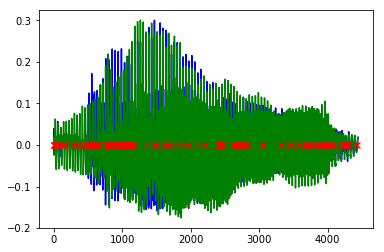

In [427]:
ff = lambda a,b: abs(a-b)**(0.05)

Al = DTW(ff)
a, s = Al.align(five, nine)
Al.plot(five, nine, a)

fivenine = (five[Al.xi]+nine[Al.yj])*0.5
display(Audio(data=fivenine, rate=sr))
librosa.output.write_wav('./fivenine.wav', fivenine, sr=sr)

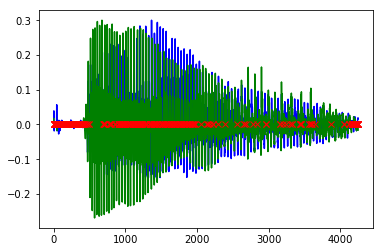

In [428]:
Al = DTW(ff)
a, s = Al.align(five, four)
Al.plot(five, four, a)

fivefour = (five[Al.xi]+four[Al.yj])*0.5
display(Audio(data=fivefour, rate=sr))
librosa.output.write_wav('./fivefour.wav', fivefour, sr=sr)

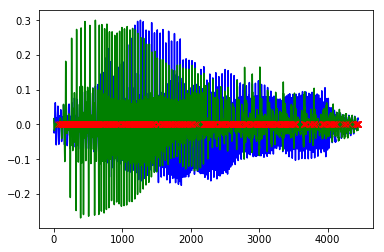

In [429]:
Al = DTW(ff)
a, s = Al.align(nine, four)
Al.plot(nine, four, a)

ninefour = (nine[Al.xi]+four[Al.yj])*0.5
display(Audio(data=ninefour, rate=sr))
librosa.output.write_wav('./ninefour.wav', ninefour, sr=sr)